In [ ]:
#Goal: be in the top 15 

In [1]:
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [25]:
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'AMZN', 'WMT', 'PG', 'META', 'TGT', 'OZEM', 'WFC', 'MA', 'NFLX', 'DIS', 'COST', 'NVDA']
USERS_STOCKS = ['OZEM', 'TGT', 'TSLA', 'WFC', 'WMT', 'DIS', 'MA', 'NFLX']
S_DATE = '2022-11-01'
E_DATE = '2024-12-15'
MOMENTUM_THRESHOLD = 0.0005
AVAILABLE_BUDGET = 1_000_000

In [27]:
all_tickers = list(set(TICKERS + USERS_STOCKS))
data = yf.download(all_tickers, start=S_DATE, end=E_DATE)
stock_data = data['Adj Close']

[*********************100%***********************]  16 of 16 completed


In [29]:
# Identify stocks with positive momentum
# Calculate percentage changes for all stocks
stock_data_pct_change = stock_data.pct_change()
positive_momentum = stock_data_pct_change.iloc[-1] > MOMENTUM_THRESHOLD

# Filter tickers with positive momentum
selected_tickers = positive_momentum[positive_momentum].index

# Retrieve stock data for the selected tickers
trade_candidates = stock_data[selected_tickers]

In [31]:
def calculate_momentum(data, threshold):
    return data.pct_change().iloc[-1] > threshold

def determine_trades(data, tickers, budget, momentum_threshold):
    trade_value = budget / 3
    trades = []
    for ticker in tickers:
        if calculate_momentum(data[ticker], momentum_threshold):
            current_price = data[ticker].iloc[-1]
            shares_to_buy = trade_value // current_price
            if shares_to_buy > 0:
                trades.append({
                    'Stock': ticker,
                    'Action': 'Buy',
                    'Shares to Buy': shares_to_buy,
                    'Price per Share': current_price,
                    'Total Cost': shares_to_buy * current_price
                })
    return trades

In [33]:
import logging
logging.basicConfig(level=logging.INFO)

logging.info("Stock data fetched successfully.")

INFO:root:Stock data fetched successfully.


In [35]:
try:
    data = yf.download(all_tickers, start=S_DATE, end=E_DATE)
    if data.empty:
        raise ValueError("No data fetched. Check ticker symbols or date range.")
except Exception as e:
    logging.error(f"Error fetching stock data: {e}")
    raise


[*********************100%***********************]  16 of 16 completed


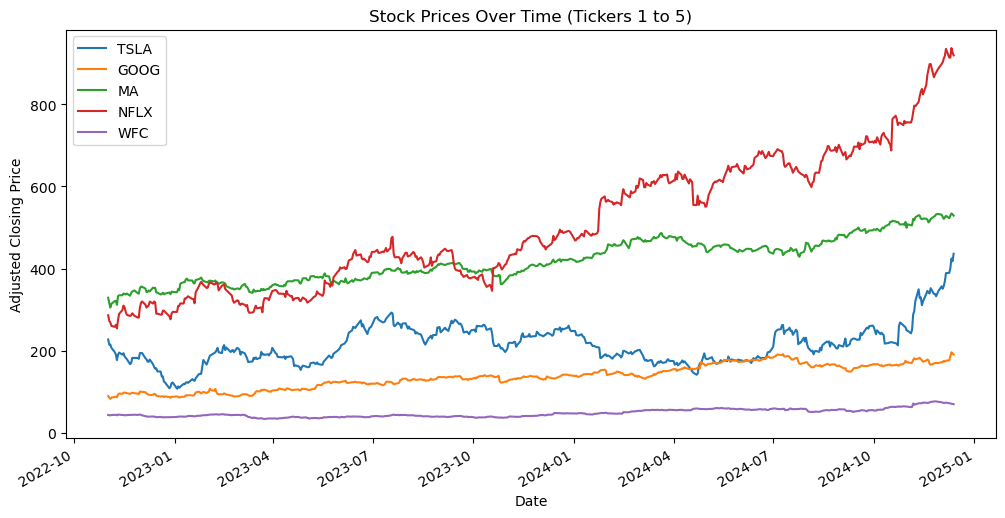

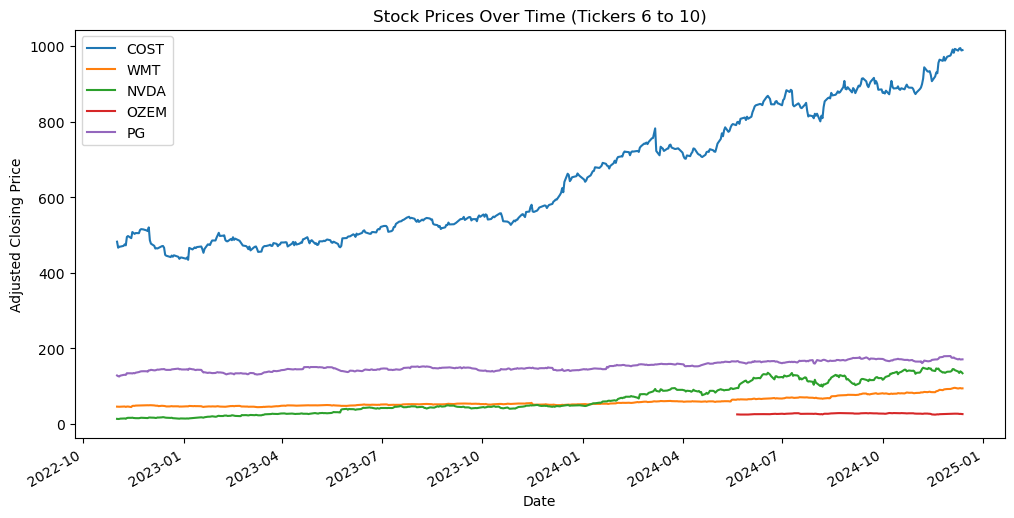

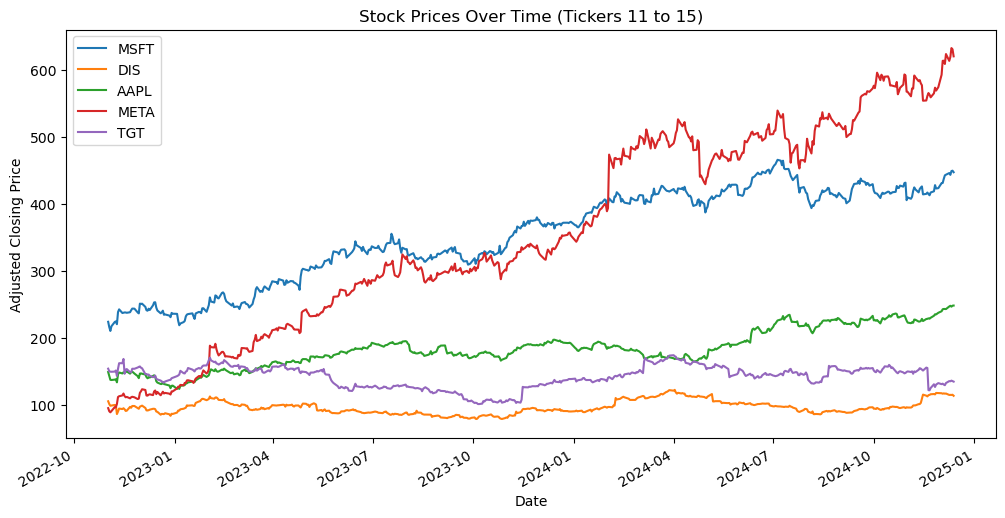

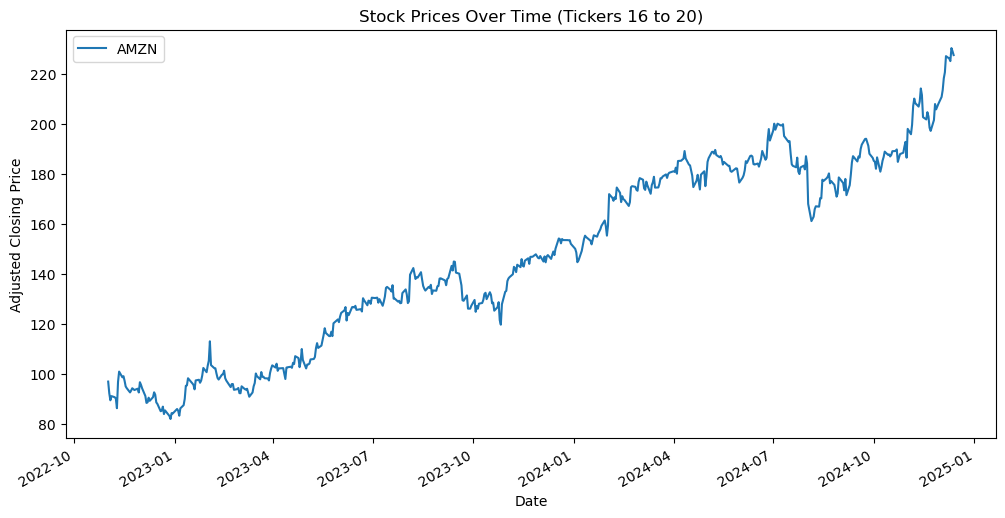

In [37]:
import math

# Define the maximum number of tickers per plot
chunk_size = 5

# Get unique tickers from stock_data columns (to ensure no duplicates)
unique_tickers = list(set(stock_data.columns))

# Determine the number of chunks required
num_chunks = math.ceil(len(unique_tickers) / chunk_size)

# Generate plots for each chunk
for i in range(num_chunks):
    # Select the current chunk of tickers
    tickers_chunk = unique_tickers[i * chunk_size:(i + 1) * chunk_size]
    
    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Plot each ticker in the current chunk
    for ticker in tickers_chunk:
        stock_data[ticker].plot(label=ticker)
    
    # Add labels, legend, and title
    plt.title(f"Stock Prices Over Time (Tickers {i * chunk_size + 1} to {(i + 1) * chunk_size})")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Closing Price")
    plt.legend()
    
    # Display the plot
    plt.show()


In [38]:
# Example: Buy stocks with positive momentum (without fallback logic)
momentum_threshold = 0.0005  # 1% change threshold

# Total available budget
available_budget = 1000000  # $1,000,000 virtual cash
trade_value = available_budget / 3  # You can split the budget evenly across 3 stocks

# Create an empty list to store trades
trades = []

# Loop through each stock and calculate its momentum
for ticker in TICKERS:
    recent_change = stock_data_pct_change[ticker].iloc[-1]
    if recent_change > momentum_threshold:
        # Fetch the current price of the stock
        current_price = stock_data[ticker].iloc[-1]
        
        # Calculate the number of shares to buy based on the available budget for each stock
        shares_to_buy = trade_value // current_price
        if shares_to_buy > 0:
            trades.append({
                'Stock': ticker, 
                'Action': 'Buy', 
                'Reason': 'Positive momentum', 
                'Shares to Buy': shares_to_buy,
                'Price per Share': current_price,
                'Total Cost': shares_to_buy * current_price
            })

# Display trade decisions
pd.DataFrame(trades)

,Stock,Action,Reason,Shares to Buy,Price per Share,Total Cost
0,AAPL,Buy,Positive momentum,1343.0,248.130005,333238.596558
1,TSLA,Buy,Positive momentum,764.0,436.230011,333279.728394
2,WMT,Buy,Positive momentum,3536.0,94.250000,333268.000000
3,PG,Buy,Positive momentum,1948.0,171.059998,333224.875244
4,COST,Buy,Positive momentum,336.0,989.349976,332421.591797


In [41]:
#What to sell
#enter what stocks you already have 
#if you are loosing a lot at a large momentum then sell
# Define the user's current portfolio
UsersStocks = ['OZEM','TGT', 'TSLA', 'WFC','WMT', 'DIS', 'MA', 'NFLX' ]  # Replace with the tickers the user owns

# Fetch data only for the user's stocks
user_data = yf.download(UsersStocks, start=S_DATE, end=E_DATE)
user_stock_data = user_data['Adj Close']

# Calculate percentage change in stock prices for user's stocks
user_stock_data_percentage_change = user_stock_data.pct_change()

# Define thresholds for keeping or selling stocks
momentum_keep_threshold = 0.01  # Keep if momentum is above 1%
momentum_sell_threshold = -0.02  # Sell if momentum is below -2%
stop_loss_threshold = -0.05  # Stop-loss threshold (5% drop)

# Function to analyze stock performance and make decisions
def analyze_stock(ticker, recent_change, current_price, avg_price):
    if recent_change > momentum_keep_threshold:
        return {
            'Stock': ticker,
            'Action': 'Keep',
            'Reason': 'Positive momentum',
            'Current Price': current_price,
            'Average Price': avg_price
        }
    elif recent_change < momentum_sell_threshold:
        return {
            'Stock': ticker,
            'Action': 'Sell',
            'Reason': 'Negative momentum',
            'Current Price': current_price,
            'Average Price': avg_price
        }
    elif current_price < avg_price * (1 + stop_loss_threshold):
        return {
            'Stock': ticker,
            'Action': 'Sell',
            'Reason': 'Stop-loss triggered',
            'Current Price': current_price,
            'Average Price': avg_price
        }
    else:
        return {
            'Stock': ticker,
            'Action': 'Hold',
            'Reason': 'Neutral momentum',
            'Current Price': current_price,
            'Average Price': avg_price
        }

# Calculate average prices (or use a moving average)
user_average_prices = user_stock_data.mean()

# Create a list to store keep/sell suggestions for user's stocks
keep_sell_decisions = []

# Loop through each stock in UsersStocks and analyze it
for ticker in UsersStocks:
    recent_change = user_stock_data_percentage_change[ticker].iloc[-1]
    current_price = user_stock_data[ticker].iloc[-1]
    avg_price = user_average_prices[ticker]
    
    # Get the decision
    decision = analyze_stock(ticker, recent_change, current_price, avg_price)
    keep_sell_decisions.append(decision)

# Display keep/sell decisions for user's stocks
pd.DataFrame(keep_sell_decisions)

[*********************100%***********************]  8 of 8 completed


,Stock,Action,Reason,Current Price,Average Price
0,OZEM,Hold,Neutral momentum,26.170000,27.189340
1,TGT,Sell,Stop-loss triggered,134.520004,141.651586
2,TSLA,Keep,Positive momentum,436.230011,215.520037
3,WFC,Hold,Neutral momentum,70.440002,48.652001
4,WMT,Hold,Neutral momentum,94.250000,58.480611
5,DIS,Hold,Neutral momentum,113.339996,96.169071
6,MA,Hold,Neutral momentum,529.000000,418.874384
7,NFLX,Hold,Neutral momentum,918.869995,504.806116


In [43]:
#Goal: to view my current stocks that currently have negative momentum and prediciting if the momentum is expected to rise or not
# if rise then buy more stocks 
#if decline then sell/ cut losses 
#currently having trouble with displaying, it works in my pass models but not in this current model 
# Define the user's tickers and negative momentum threshold
users_tickers = UsersStocks  # Replace with the user's tickers if different
negative_momentum_threshold = 0  # Negative value threshold for momentum

# Define moving average windows
short_term_window = 5
long_term_window = 20

# Create a list to store decisions
predictions = []

# Loop through each user's ticker
for ticker in users_tickers:
    if ticker in stock_data_pct_change.columns:
        # Get recent momentum
        recent_change = stock_data_pct_change[ticker].iloc[-1]
        
        # Skip if the stock's momentum is not negative
        if recent_change >= negative_momentum_threshold:
            continue

        # Calculate short-term and long-term moving averages
        short_term_avg = stock_data[ticker].rolling(window=short_term_window).mean().iloc[-1]
        long_term_avg = stock_data[ticker].rolling(window=long_term_window).mean().iloc[-1]
        
        # Check if moving averages are valid
        if pd.isna(short_term_avg) or pd.isna(long_term_avg):
            print(f"{ticker}: Not enough data for moving averages")
            continue
        
        # Fetch the current stock price
        current_price = stock_data[ticker].iloc[-1]

        # Debugging output
        print(f"{ticker}: Recent Change = {recent_change}, Short-term Avg = {short_term_avg}, Long-term Avg = {long_term_avg}")

        # Predict if the stock is likely to rise or decline
        if short_term_avg > long_term_avg:
            action = "Buy"
            reason = "Likely to rebound based on moving averages"
        else:
            action = "Sell"
            reason = "Likely to decline based on moving averages"

        # Append the prediction to the list
        predictions.append({
            'Stock': ticker,
            'Action': action,
            'Reason': reason,
            'Current Price': current_price,
            'Short-term Average': short_term_avg,
            'Long-term Average': long_term_avg,
            'Recent Change': recent_change
        })

# Display the predictions
predictions_df = pd.DataFrame(predictions)

if predictions_df.empty:
    print("No predictions to display. Check the filtering conditions or input data.")
else:
    print(predictions_df)

OZEM: Recent Change = -0.006454065121834995, Short-term Avg = 26.591999816894532, Long-term Avg = 26.301350021362303
TGT: Recent Change = -0.0056913966433820296, Short-term Avg = 135.2259979248047, Long-term Avg = 133.95418739318848
WFC: Recent Change = -0.005084754164323746, Short-term Avg = 71.502001953125, Long-term Avg = 74.09200019836426
DIS: Recent Change = -0.013577068470594589, Short-term Avg = 114.43800048828125, Long-term Avg = 115.41050033569336
MA: Recent Change = -0.0064047882581748095, Short-term Avg = 529.5380004882812, Long-term Avg = 525.5794982910156
NFLX: Recent Change = -0.007217322417895633, Short-term Avg = 921.6039916992188, Long-term Avg = 894.7694946289063
  Stock Action                                      Reason  Current Price  \
0  OZEM    Buy  Likely to rebound based on moving averages      26.170000   
1   TGT    Buy  Likely to rebound based on moving averages     134.520004   
2   WFC   Sell  Likely to decline based on moving averages      70.440002   
3 